In [1]:
# import necessary libraries
from keras.applications import VGG16
from keras import backend as K
import numpy as np

Using TensorFlow backend.


In [2]:
# Define the loss tensore for filter visualization
model = VGG16(weights='imagenet', include_top=False)
layer_name = 'block3_conv1'
filter_index = 0
layer_output = model.get_layer(layer_name).output
loss = K.mean(layer_output[:,:,:, filter_index])

In [3]:
# Utility function to convert a tensor into valid image
def deprocess_image(x):
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1
    
    x += 0.5
    x = np.clip(x, 0, 1)
    
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [4]:
def generate_pattern(layer_name , filter_index, size = 150):
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:, :, :, filter_index])
    
    # Obtainign the gradient of the loss with regards to the input
    grads = K.gradients(loss, model.input)[0]
    
    # normalize gradient
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)
    
    # For fetching numpy output values given Numpy input values
    iterate = K.Function([model.input],[loss,grads])
    import numpy as np
    loss_value, grads_value = iterate([np.zeros((1,150,150,3))])
    
    # Loss maximization via stochasitc gradient descent
    input_img_data = np.random.random((1,150,150,3))* 20 + 128.
    step = 1.
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
    
    img = input_img_data[0]
    return deprocess_image(img)

In [5]:
import matplotlib.pyplot as plt
plt.imshow(generate_pattern("block4_conv1",0))
plt.savefig("block4_conv1")
plt.title("block4_conv1.jpg")
plt.show()

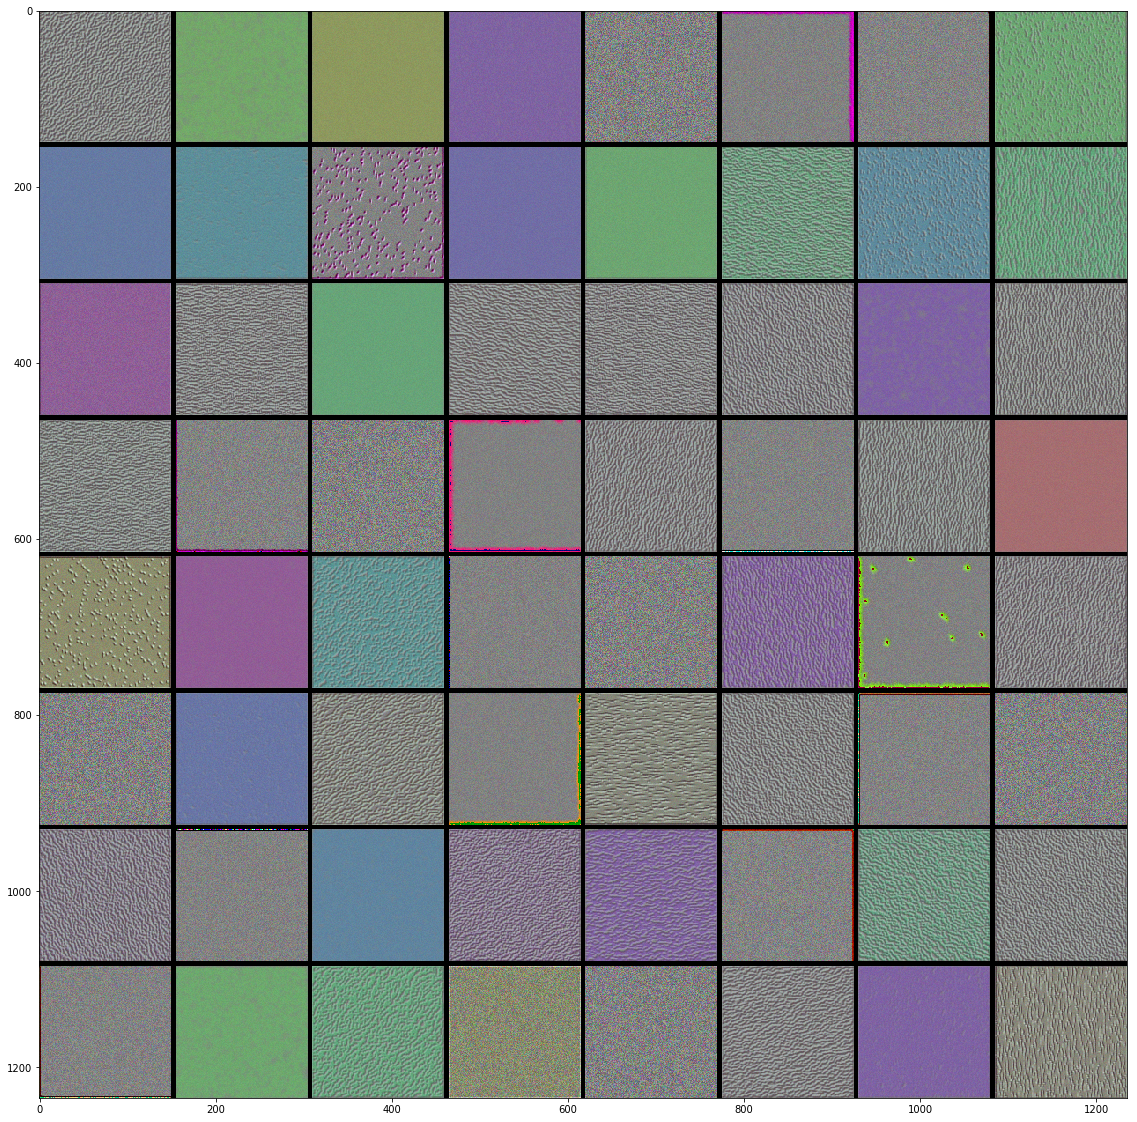

In [6]:
layer_name = 'block1_conv1'
size = 150
margin = 5

results = np.zeros((8 * size + 7 * margin, 8 * size + 7 * margin, 3))

for i in range(8):
    for j in range(8):
        filter_img = generate_pattern(layer_name, i + (j * 8), size = size)
        horizontal_start = i * size + i * margin
        horizontal_end = horizontal_start + size
        vertical_start = j * size + j * margin
        vertical_end = vertical_start + size
        results[horizontal_start: horizontal_end,
                vertical_start : vertical_end, :] = filter_img
plt.figure(figsize=(20,20))
plt.imshow(results)
plt.savefig("block1_conv1_color.jpg")